## clase 13 de marzo modelos recurrentes [cuaderno clase](https://nbviewer.org/github/AprendizajeProfundo/Diplomado/blob/master/Temas/M%C3%B3dulo%205-%20Redes%20recurrentes/Cuadernos/rnr_Times_series_Intro-lstm.ipynb)

In [20]:
# Importar módulos requeridos
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from tensorflow import keras
#
from tensorflow.keras.layers import Input, LSTM, Dense, GRU
from tensorflow.keras.models import Model
#
from tensorflow.keras.optimizers import Adam
#
from tensorflow.keras.utils import plot_model
#
from sklearn.preprocessing import MinMaxScaler
#
print("Versión de Tensorflow: ", tf.__version__)

Versión de Tensorflow:  2.10.1


In [2]:
# Configuraciones básicas generales
%matplotlib inline
%config InlineBackend.figure_format='retina'
#
#sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10
#

#tf.random.set_seed(RANDOM_SEED)
#

# Ejemplos cuaderno [cuaderno](https://nbviewer.org/github/AprendizajeProfundo/Diplomado/blob/master/Temas/M%C3%B3dulo%205-%20Redes%20recurrentes/Cuadernos/rnr_LSTM_Intro.ipynb)

In [25]:
import tensorflow as tf
inputs = tf.random.normal([32,10,8]) # el primero es el tamaño del lote, numero obcervaciones para predecir y el ultimo el numero de canales
lstm = tf.keras.layers.LSTM(4) # lstm es una capa de tamaño de salidad 4.
output = lstm(inputs)
print (output.shape)

(32, 4)


### Recibiendo toda la secuencia del valor del estado oculto
En algunos casos es necesario disponer del valor del estado oculto para cada valor en la secuencia de entrada. Esta secuencia tiene tamaño [batch_size, time_step, output_size] En el siguiente ejemplo se tiene que

return_sequences son todos lo estados del estado oculto
return_state es el último valor del estado oculto
final_carry_state es el último valor de la banda transportadora

In [26]:
lstm = tf.keras.layers.LSTM(4, return_sequences = True, return_state=True)
whole_seq_output, final_memory_state, final_carry_state = lstm(inputs)

In [27]:
print(whole_seq_output.shape)
print(final_memory_state.shape)
print(final_carry_state.shape)

(32, 10, 4)
(32, 4)
(32, 4)


## Datos sintéticos
Vamos a generar unos datos que siguen un comportamiento sinosoidal, con una tendencia ascendiente. Se introduce ruido Gaussiano.

Modifique las siguientes dos líneas y haga su priopia simulación.

In [3]:
#
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
trend = .1
#
time = np.arange(0, 100, 0.1)
sin =  trend*time + np.sin(time) + np.random.normal(scale=0.5, size=len(time))

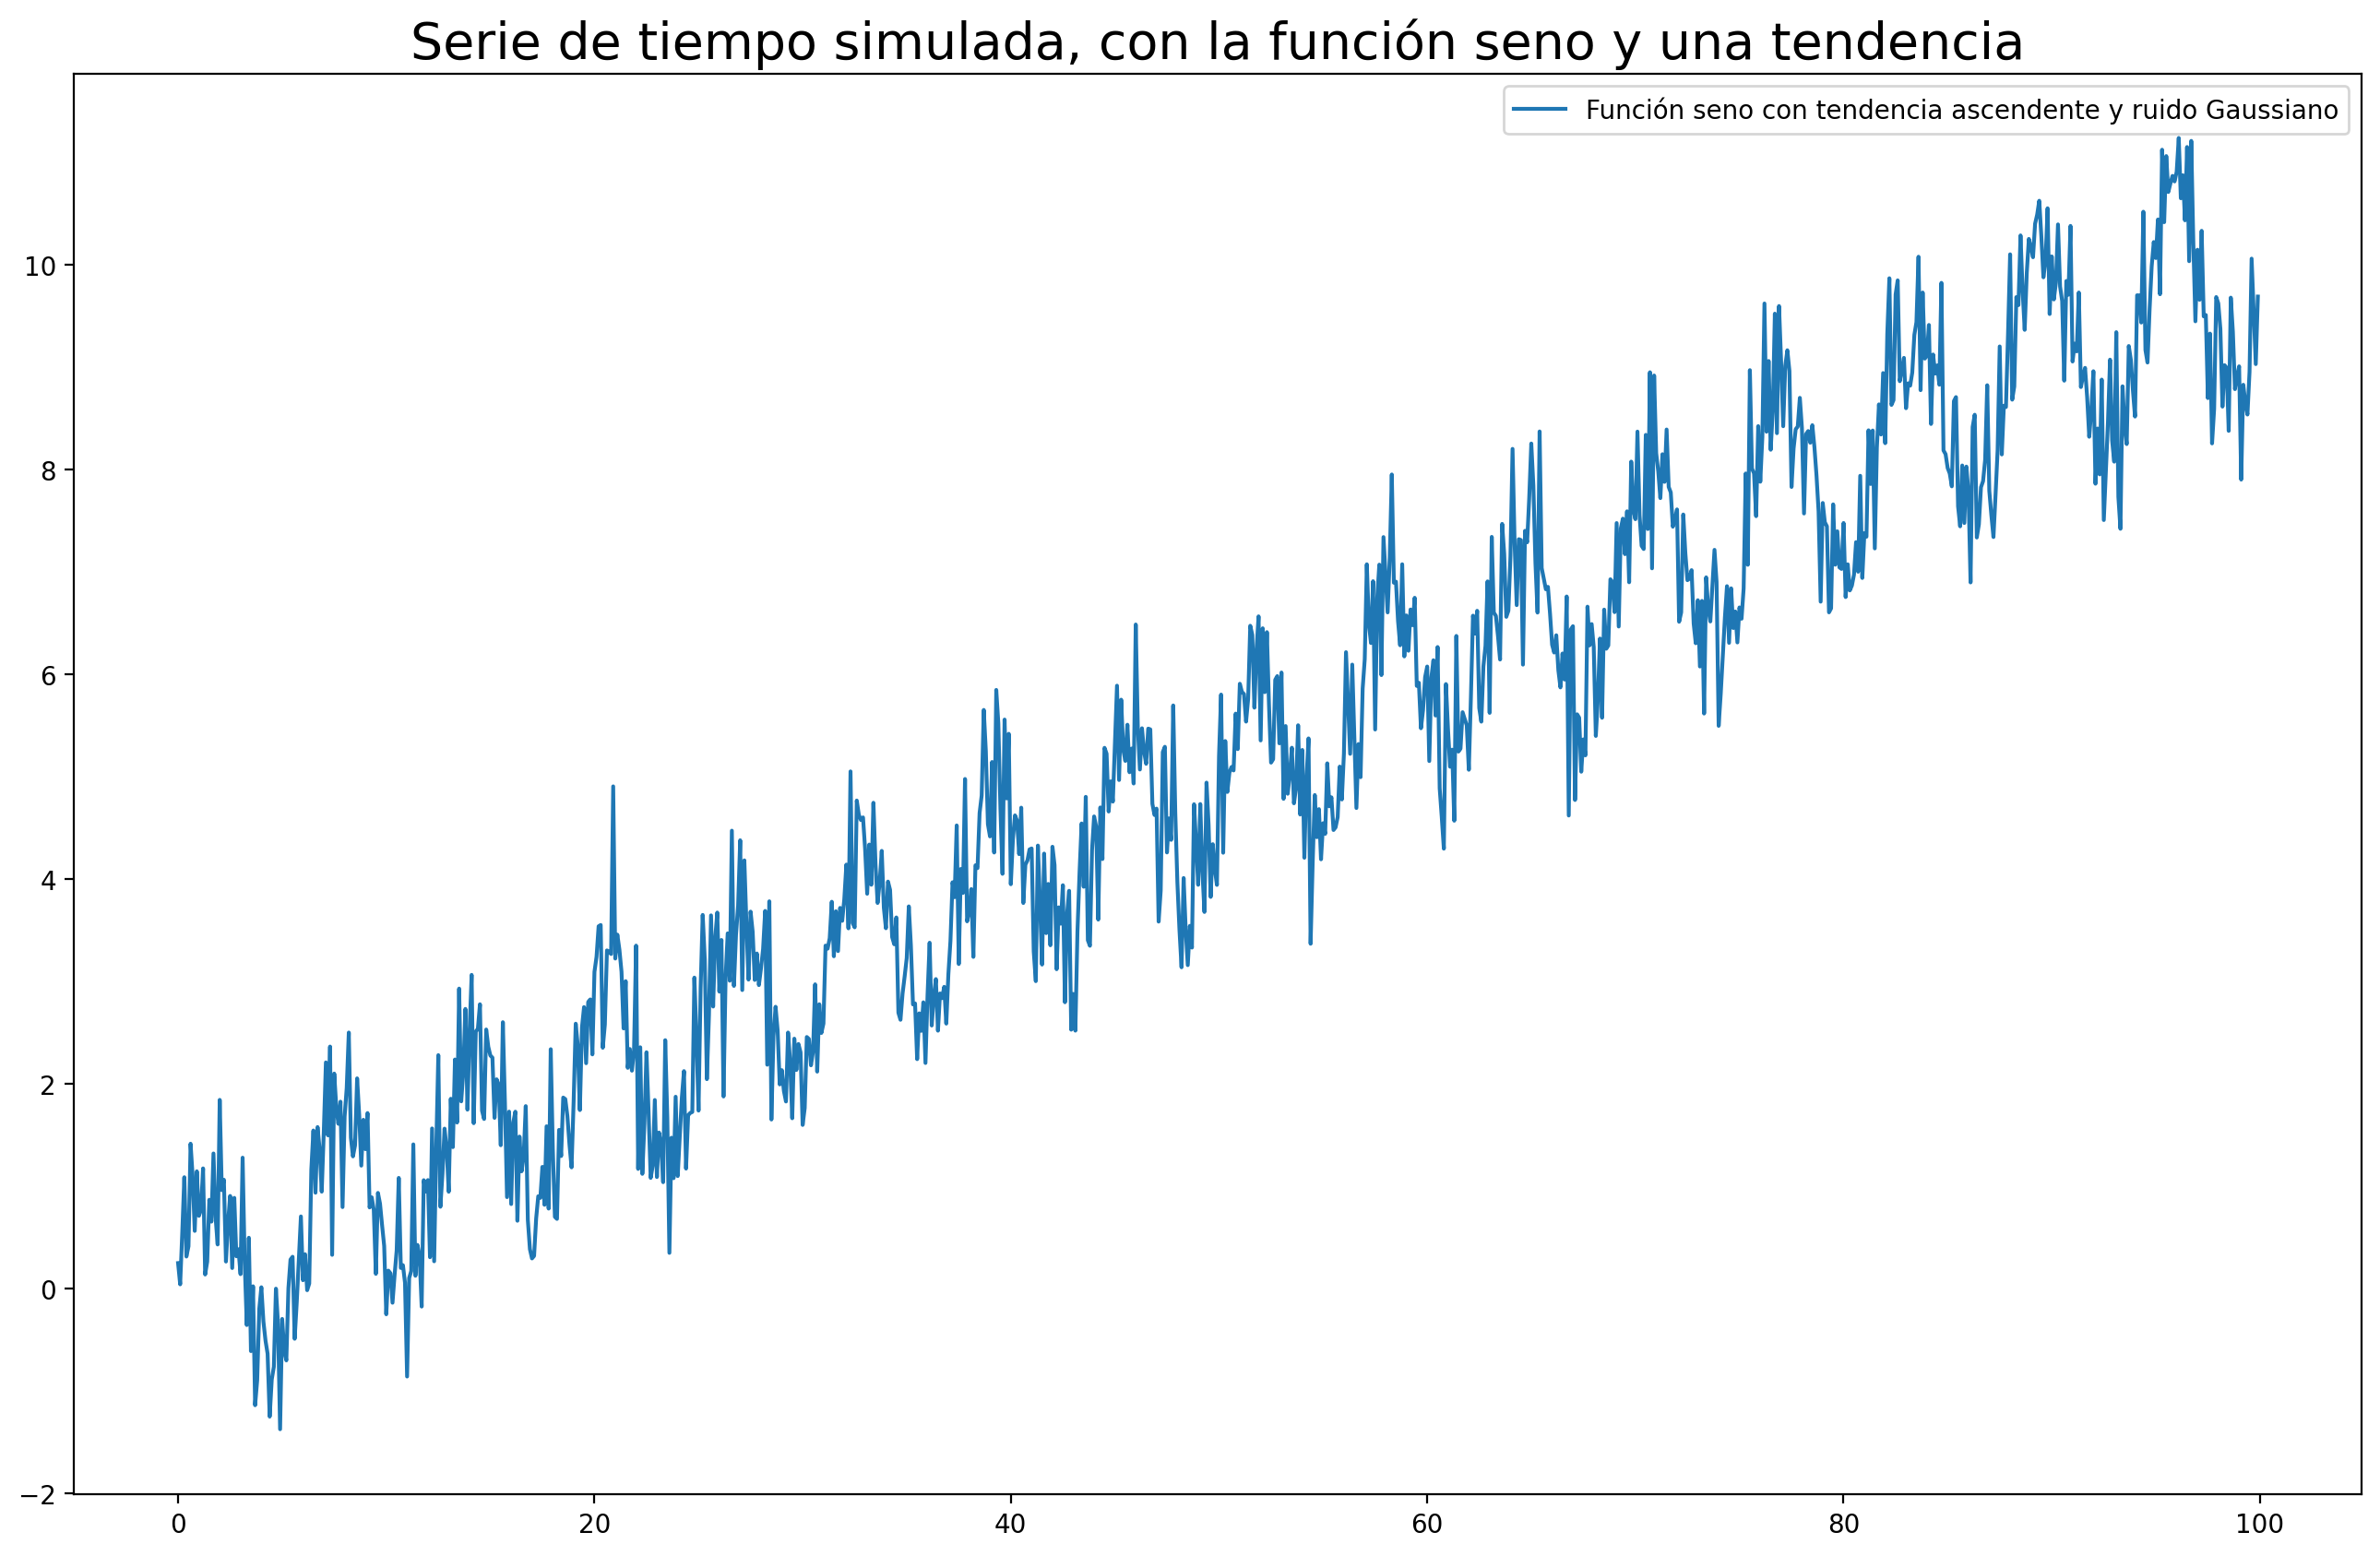

In [4]:
plt.plot(time, sin, label='Función seno con tendencia ascendente y ruido Gaussiano');
plt.title("Serie de tiempo simulada, con la función seno y una tendencia", size = 20)
plt.legend();
plt.show()

In [5]:
print( 'Número de datos: ', sin.shape[0])

Número de datos:  1000


## Preprocesamiento de los datos
Escala los datos
Introducimos un instancia de clase del escalador MinMaxScaler para llevar los datos a la escala [0,1]

In [6]:
#crea un dataset 
#
df1 = pd.DataFrame(sin, index=time, columns=['serie'])
# crea el objeto  scaler y escala los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df1.values)
#
dataset = pd.DataFrame(scaled_data,index=df1.index, columns=['serie'])
#

In [7]:
dataset.shape

(1000, 1)

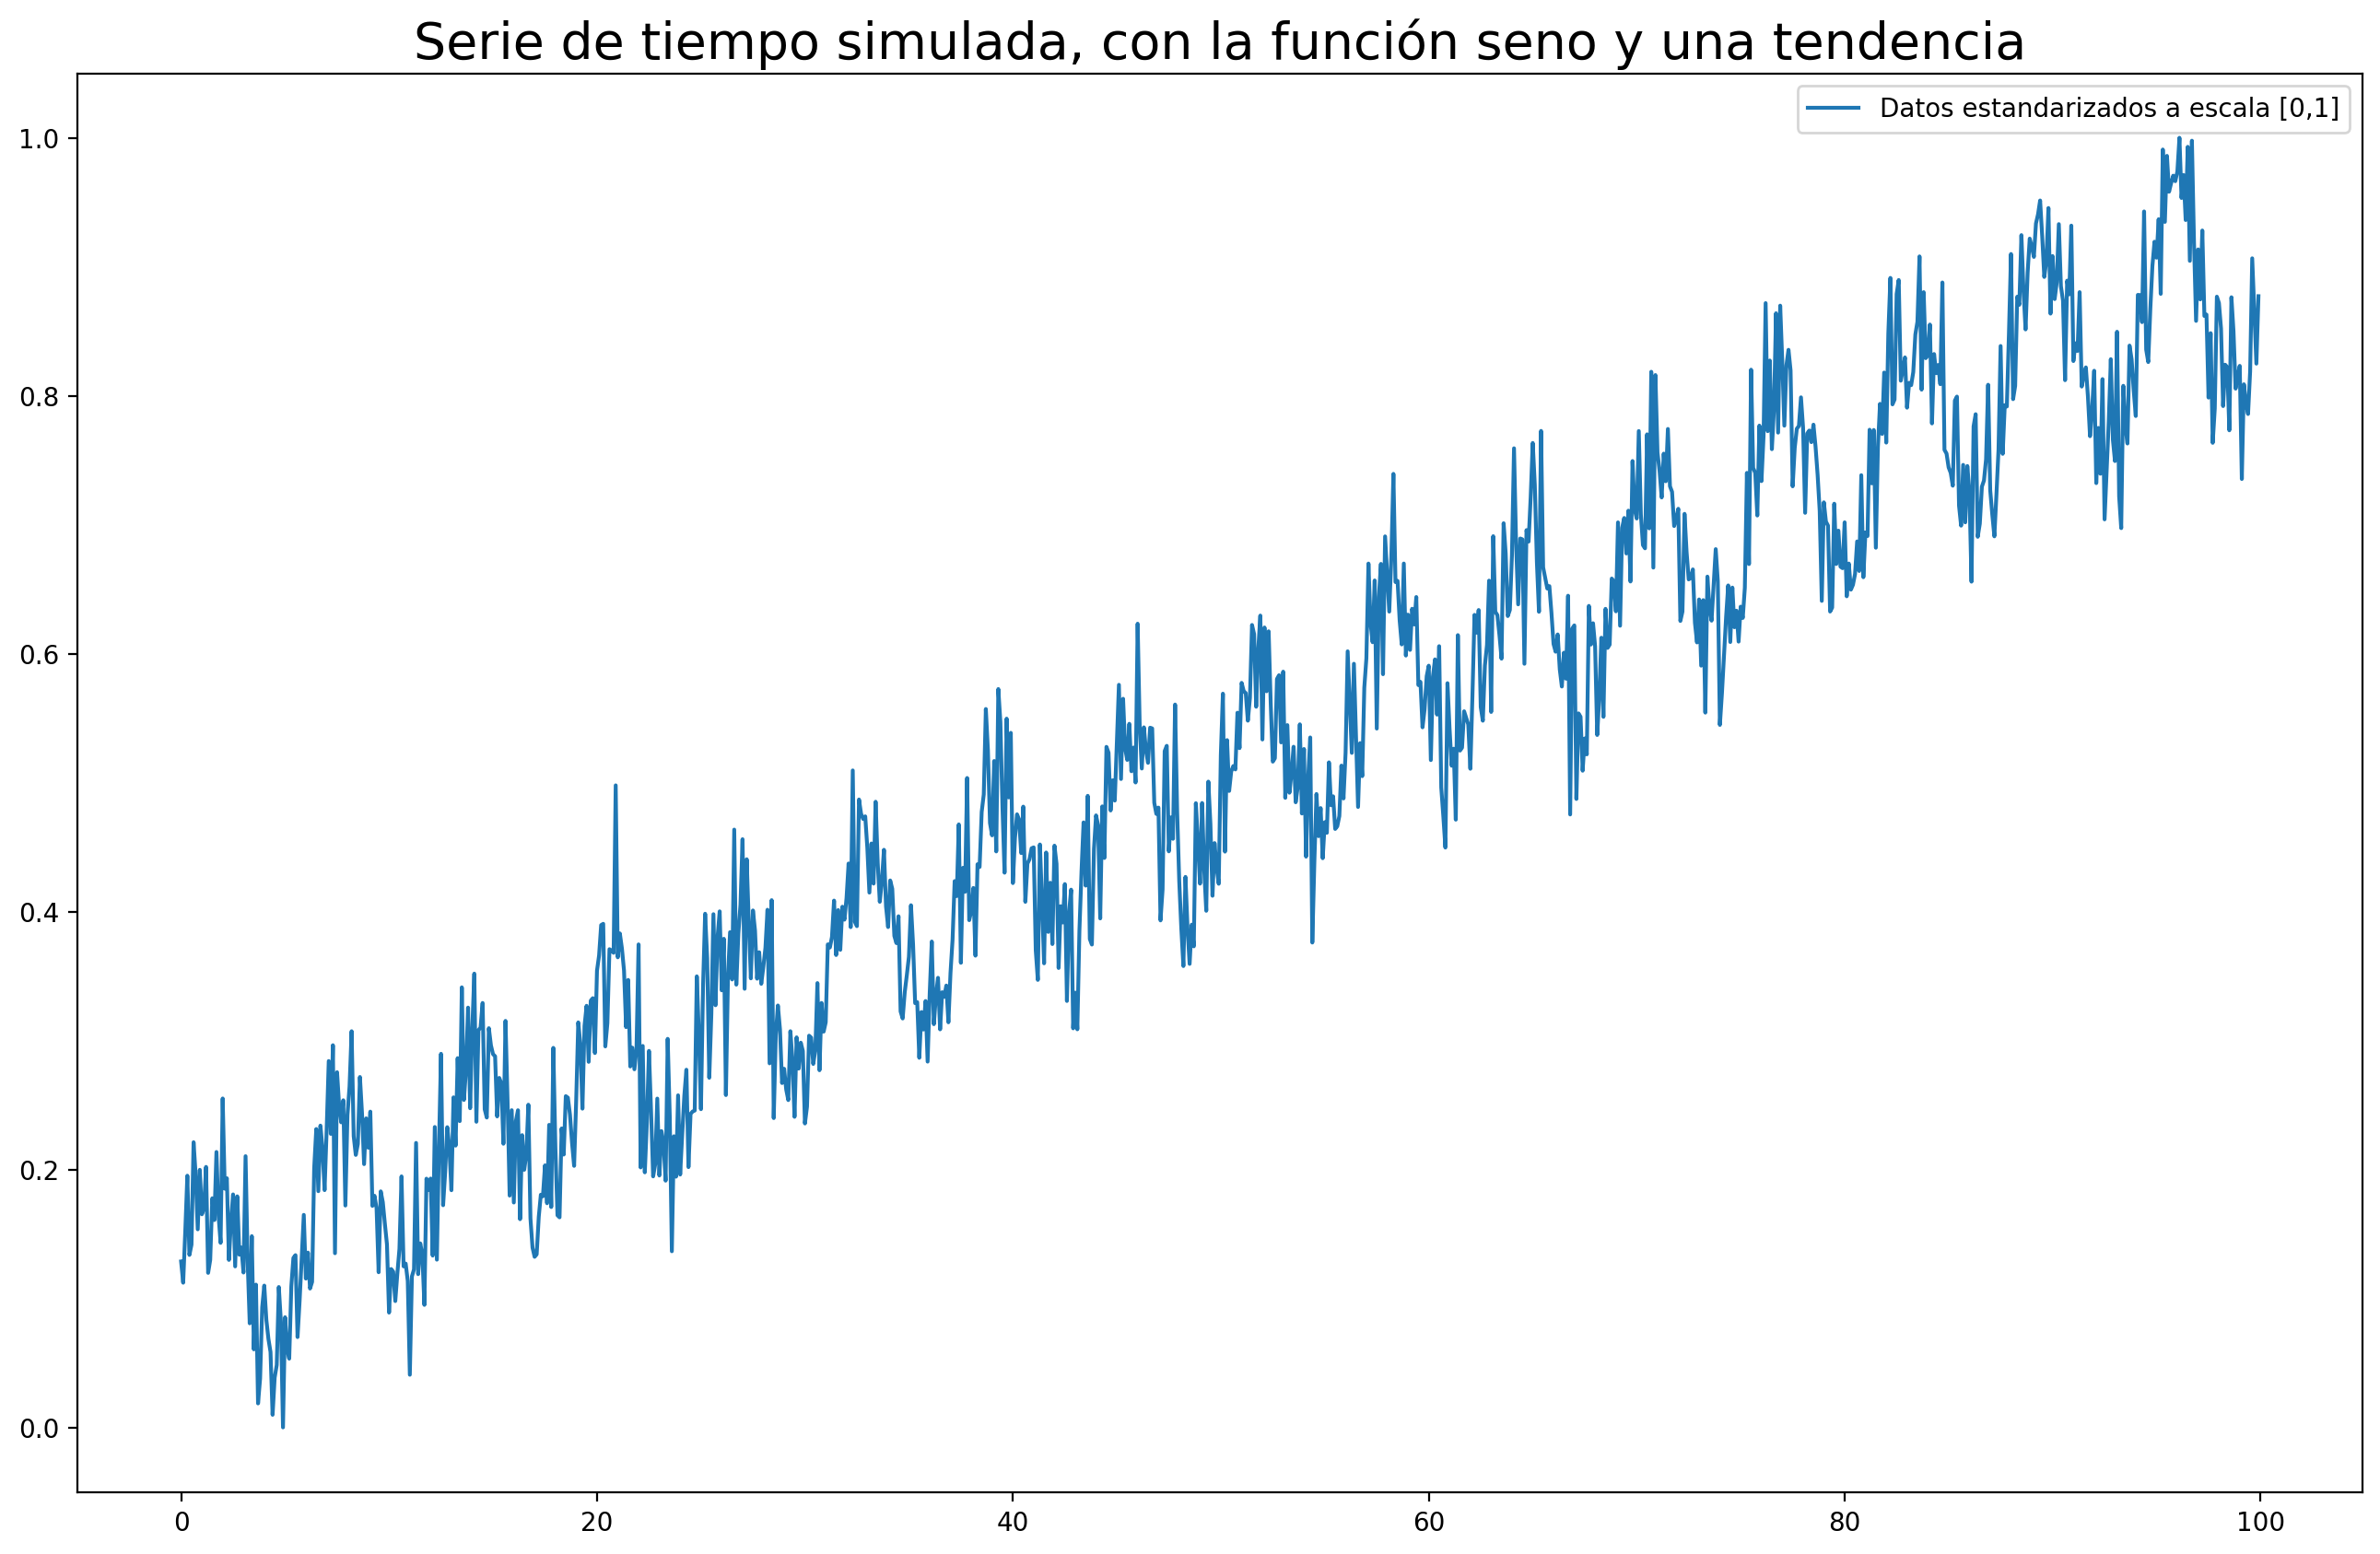

In [8]:
# Gráfico de datos escalados
#serie_0_1 = dataset.serie_0_1.values

plt.plot(time, dataset, label='Datos estandarizados a escala [0,1]');
plt.title("Serie de tiempo simulada, con la función seno y una tendencia", size = 20)
plt.legend();
plt.show()

## Separación de datos entrenamiento y de validación
En el caso de las series de tiempo, los datos de entrenamiento se toman desde el comienzo de la serie y los de validación desde el final hacia atras.

Veamos.

In [9]:
train_size = int(len(dataset) * 0.8) ##regla del 80 20 usamos
test_size = len(dataset) - train_size
train, test = dataset.iloc[0:train_size], dataset.iloc[train_size:len(df1)]# uso de la asignacion multiple
len_train = len(train)
len_test = len(test)
print(len_train, len_test)

800 200


In [10]:
train.shape

(800, 1)

In [11]:
test.shape

(200, 1)

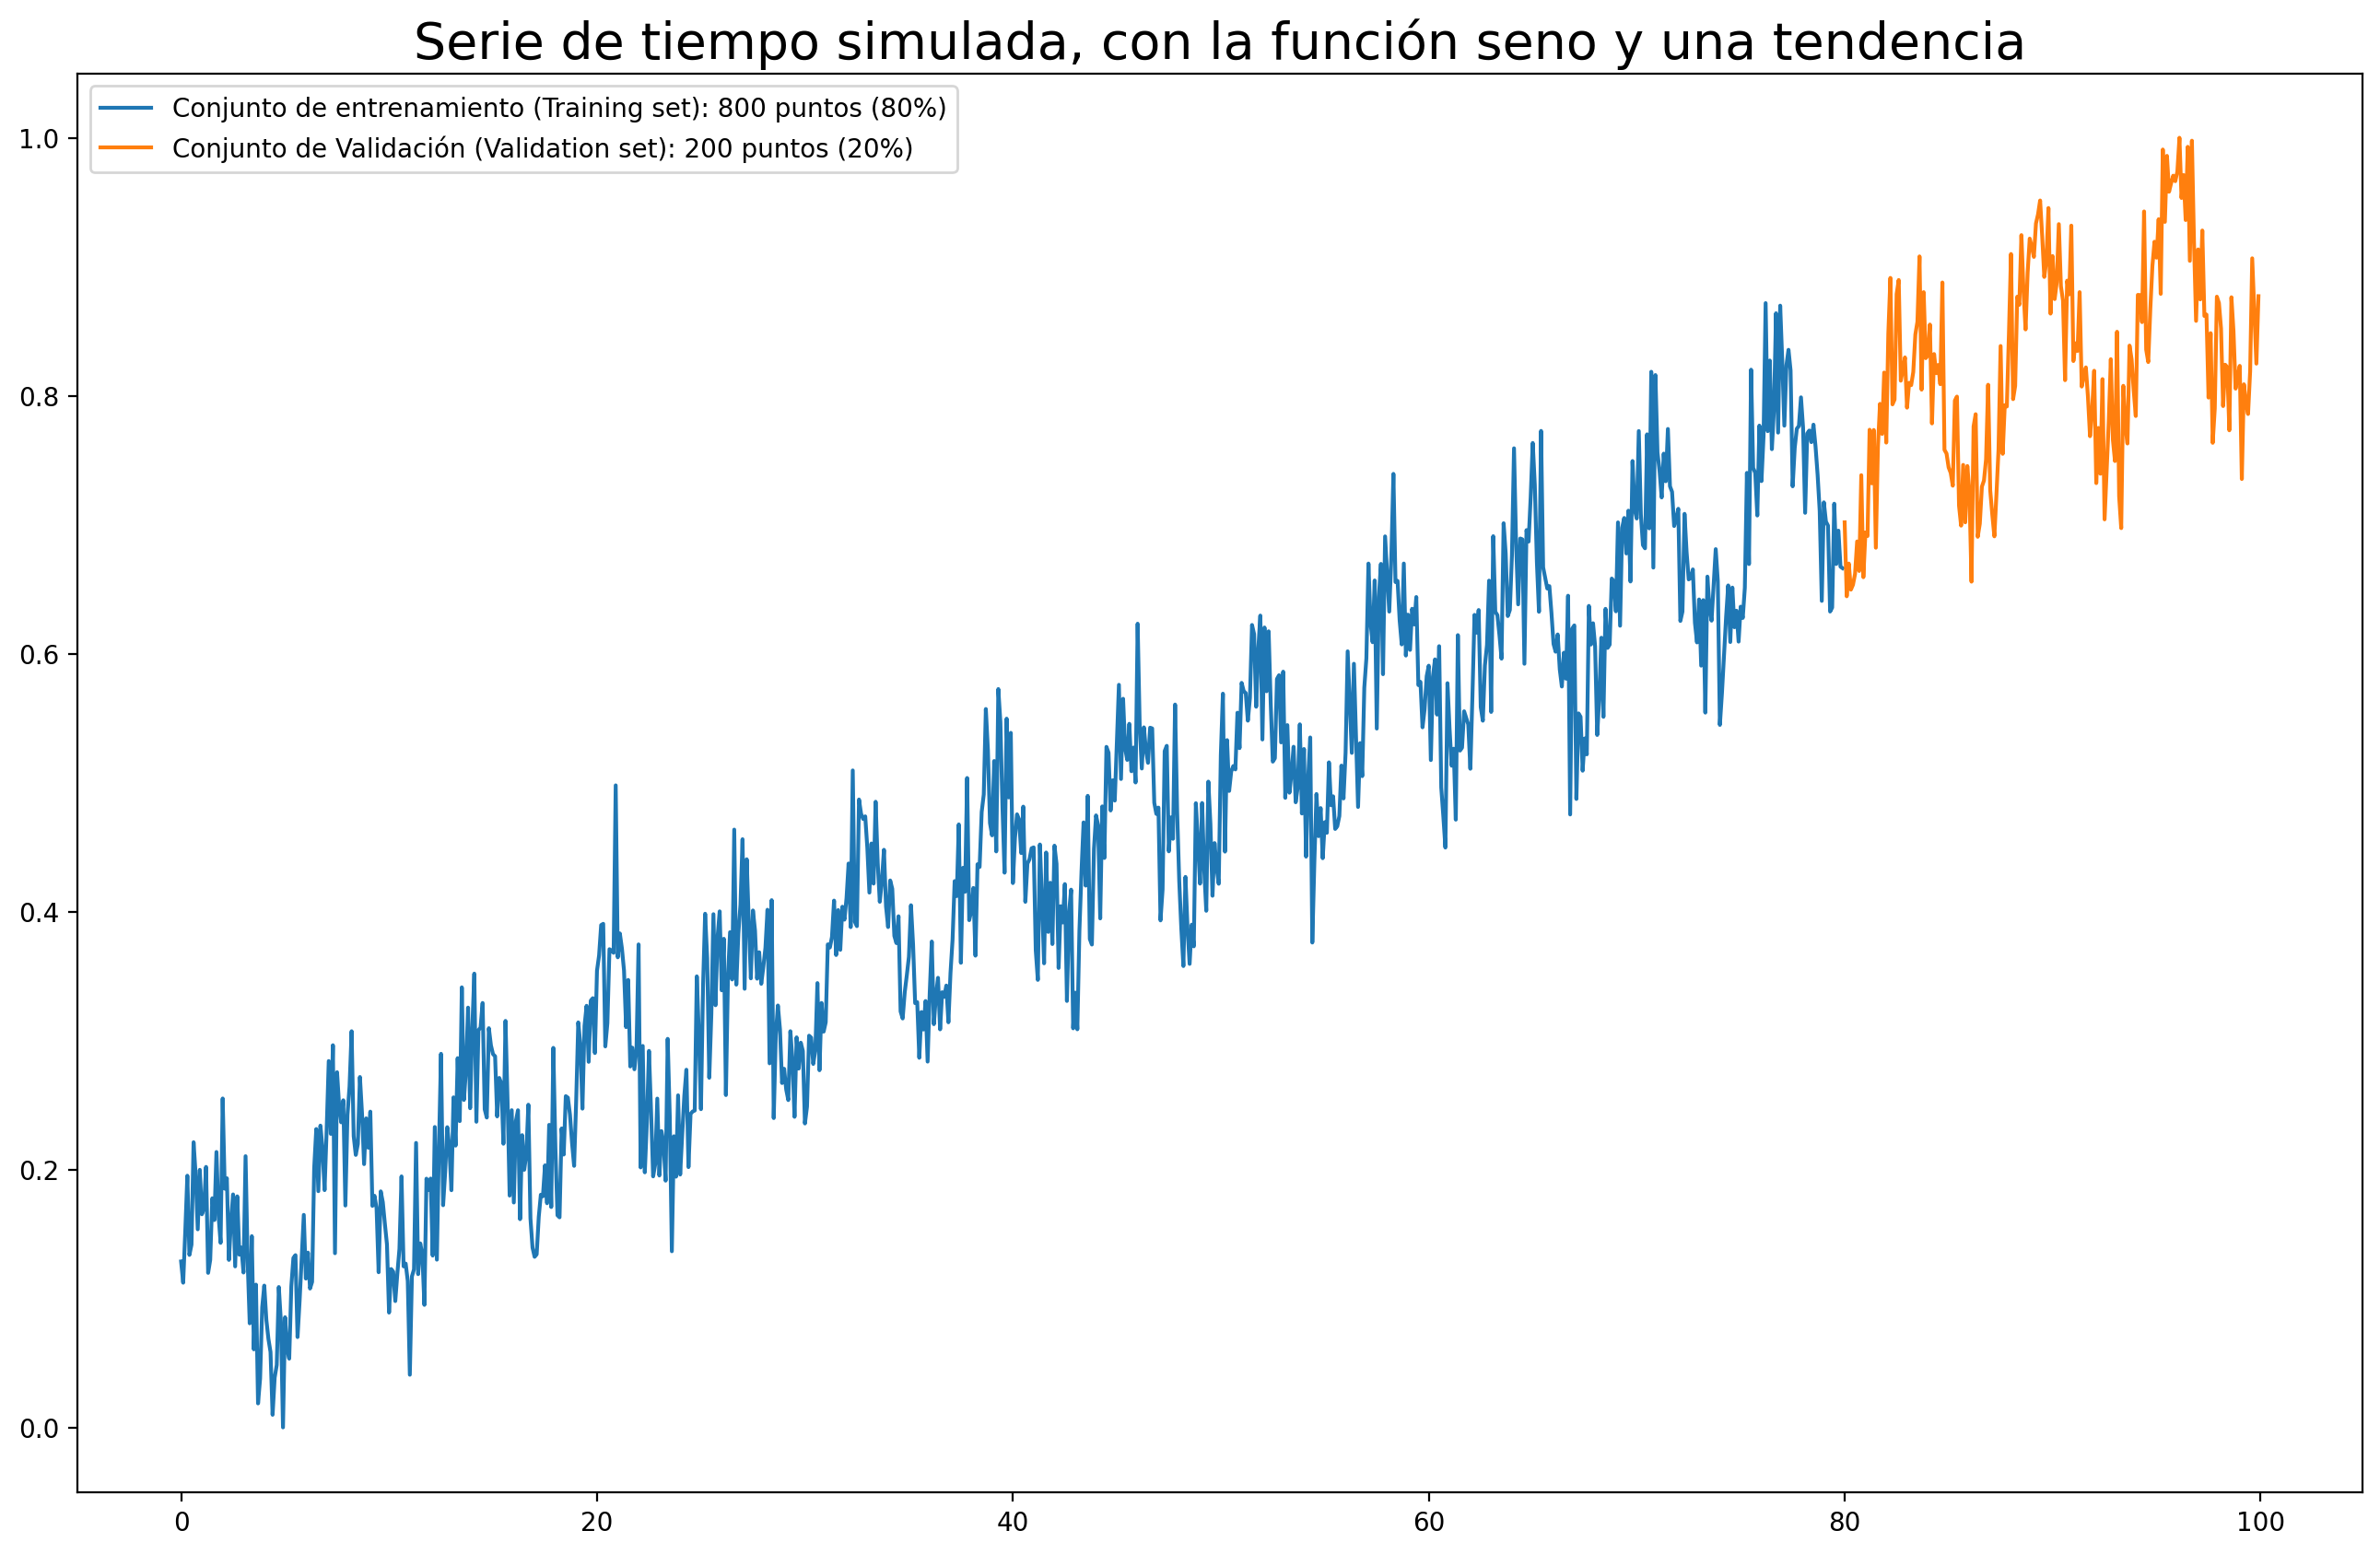

In [12]:
#Plot que muestra los datos de entrenamiento y los de validación
#plt.figure(figsize=(16,8))
plt.plot(train, label='Conjunto de entrenamiento (Training set): ' + str(len_train) +' puntos (80%)')
plt.plot(test, label='Conjunto de Validación (Validation set): '  + str(len_test) + ' puntos (20%)') 
plt.title("Serie de tiempo simulada, con la función seno y una tendencia", size = 20)
plt.legend()
plt.show()

Preparar los datos para la predicción de series temporales (LSTM en particular) puede ser complicado.

Intuitivamente, necesitamos predecir el valor en el paso de tiempo actual utilizando el historial (n
 pasos de tiempo hacia atrás a partir de él).

Aquí se propone una función genérica que hace el trabajo




## lo haemos luego es la preparacion de los datos.

In [13]:
def create_dataset(X, y, time_steps=1):
    # crea dos listas vacias para depositar los datos
    Xs, ys = [], []
    # el primer lote de datos empieza en la primera observación
    # y toma time_steps  datos.
    # Comienza a avanzar hacia adelante.
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

La belleza de esta función es que trabaja con datos de series temporales univariadas (función única) y multivariadas (funciones múltiples). Usemos un historial de 50 pasos de tiempo para hacer nuestras secuencias. Esto significa que vamos a conservar la historia de 50 pasos atrás para predecir el valor actual.

In [14]:
time_steps = 50

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train, time_steps)
X_test, y_test = create_dataset(test, test, time_steps)

print(X_train.shape, y_train.shape)

print([X_train[0:2,], y_train[0:2]])

(750, 50, 1) (750, 1)
[array([[[0.12866229],
        [0.1121937 ],
        [0.15199099],
        [0.19517542],
        [0.13373672],
        [0.14166865],
        [0.2211258 ],
        [0.19603986],
        [0.15358548],
        [0.19974127],
        [0.16525499],
        [0.16990083],
        [0.20199465],
        [0.11982438],
        [0.12982285],
        [0.17767362],
        [0.16076588],
        [0.21355511],
        [0.16446774],
        [0.14307962],
        [0.25505916],
        [0.1851261 ],
        [0.19321062],
        [0.12984983],
        [0.15998183],
        [0.18065415],
        [0.12482759],
        [0.17917075],
        [0.13392128],
        [0.13937234],
        [0.12008995],
        [0.21029807],
        [0.12917938],
        [0.0806848 ],
        [0.14828083],
        [0.0604929 ],
        [0.11070353],
        [0.01858177],
        [0.03791053],
        [0.09315708],
        [0.10995165],
        [0.08338189],
        [0.06856677],
        [0.05846956],
        [

In [15]:
print(X_train.shape)
print(y_train.shape)

(750, 50, 1)
(750, 1)


## Modelo LSTM
Entrenar un modelo LSTM en Keras es fácil. Utilizaremos la capa LSTM en un modelo secuencial para hacer nuestras predicciones:

### Crea el modelo

In [16]:
# shapes
inputs_shape = (X_train.shape[1], X_train.shape[2]) ## le decimos la longitud de cada dato que va a entrar y cuantos canales de datos van a entrar.
lstm_output = 60 ## tamaño de la salida.

# layers
inputs = Input(inputs_shape)
x = LSTM(units=lstm_output, name='LSTM_layer')(inputs)
outputs = Dense(1)(x) ##percectron que nos devuelve el datos predicho.

# model
serie_0_1_model = Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')

In [17]:
inputs_shape

(50, 1)

Model: "series_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 LSTM_layer (LSTM)           (None, 60)                14880     
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________


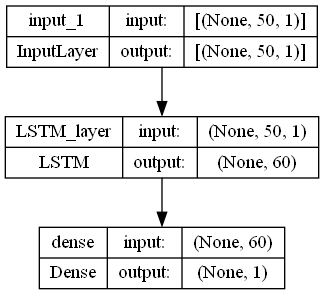

In [24]:
# Summary del modelo
#model = keras.Sequential()
#model.add(keras.layers.LSTM(units=lstm_output,  input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(keras.layers.Dense(units=1))
serie_0_1_model.summary()

plot_model(serie_0_1_model, to_file='G:/Mi unidad/2023-1/Inteligencia Artificial/Imagenes/series_LSTM_model.png', 
           show_shapes=True)

Igni Ica que e mo e o tiene a primera e tipo
(50, 1) y una salida de 60 neuronas.
capa con un Input e tamano
La segunda es una capa densa con entrada 60 neuronas y salida una neurona
EI cálculo del número de neuronas es como sigue:
Número de parámetros capa $LSTM 4(p2 + pn -F p)$
en donde p es el tamaño de salida y n el tamaño de entrada.

In [28]:
lstm_output =60
input_size =1 # input size in the LSTM machine
#
# cada entrada de tamaño 50 es mostrada a la máquina  LSTM machine uno por uno.
# luego se tiene
#
num_params = 4*(lstm_output*lstm_output + lstm_output*input_size+ lstm_output)
num_params

14880

In [29]:
#Compila
serie_0_1_model.compile(loss='mean_squared_error',
  optimizer=Adam(0.001)
)

## Entrenamiento
Lo más importante para recordar al entrenar modelos de series temporales es no mezclar los datos (el orden de los datos es importante). El resto es bastante estándar:

In [30]:
history = serie_0_1_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=True
)

Epoch 1/30
43/43 [==============================] - 2s 14ms/step - loss: 0.0227 - val_loss: 0.0028
Epoch 2/30
43/43 [==============================] - 0s 8ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 3/30
43/43 [==============================] - 0s 8ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 4/30
43/43 [==============================] - 0s 8ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 5/30
43/43 [==============================] - 0s 8ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 6/30
43/43 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 7/30
43/43 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 8/30
43/43 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 9/30
43/43 [==============================] - 0s 8ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 10/30
43/43 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 11/30
43/43 

## Evaluación del Modelo

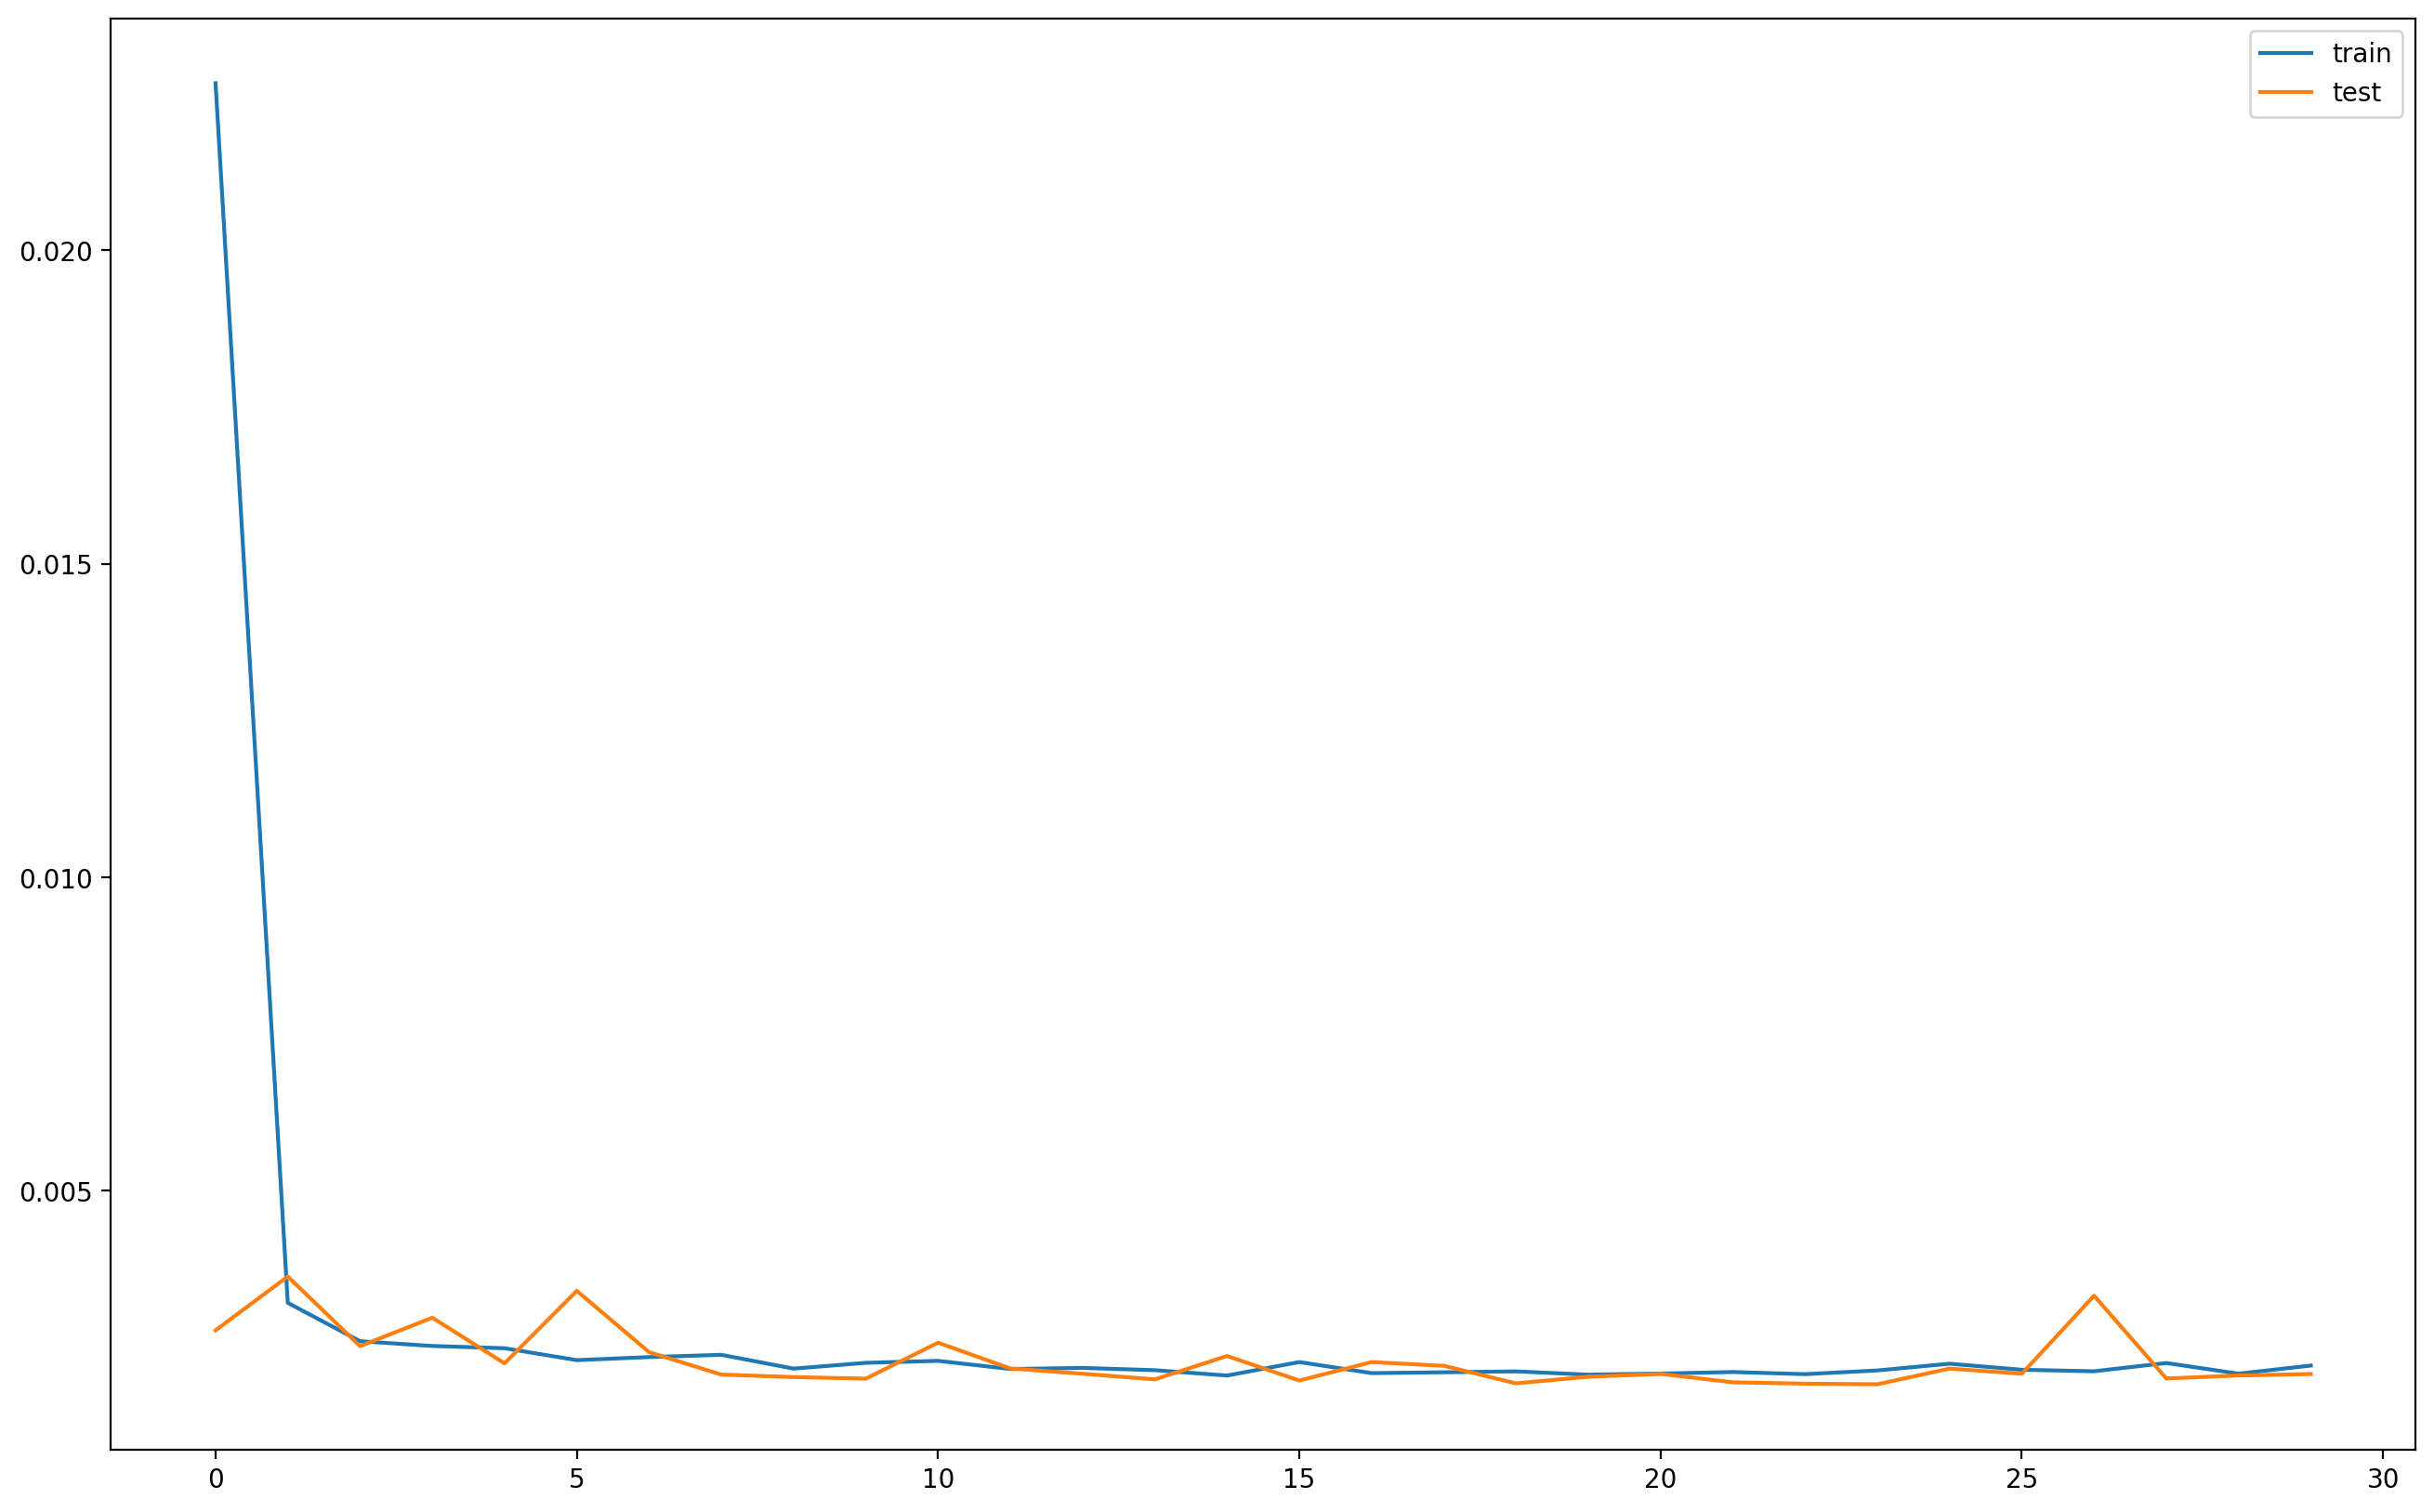

In [31]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

# Clase Operación Convolución [enlace](https://github.com/AprendizajeProfundo/Diplomado/blob/master/Temas/M%C3%B3dulo%2007%20-%20Visi%C3%B3n%20por%20computador/03%20-%20Tratamiendo%20de%20im%C3%A1genes/Cuadernos/ti_convoluciones.ipynb) 

en estas redes se basan en en ingreso de inforación se pasa por el extractor de "fiutors" caracteristicas, luego hay un perceptron para adaptar la salida a lo que necesite para resilver la tarea ej cambiar de clasificacion de 10 a 2 para reconocer por ejemplo solo se entrena la cabeza de la red con los datos nuevos.